## 시계열 예측(Time Series Forecasting) / 상권 분석 및 폐업률 예측

### 0. License 설명

Copyright 2019 The TensorFlow Author

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

https://www.tensorflow.org/tutorials/structured_data/time_series

### 1. 데이터 불러오기

In [15]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split

mpl.rcParams['axes.grid'] = True
plt.rcParams['font.family'] = 'Malgun Gothic'

데이터셋 설명
- 상권분석에는 서울시 공공데이터 포털사이트에서 다운받은 상권 데이터셋을 사용함
- 직장인구, 집객시설 수 등 8가지 변수가 포함되어 있음
- 2015년 1분기~2020년 2분기까지 총 22개의 분기동안 수집된 데이터 사용
- 총 상권의 갯수는 1496개(원핫임베딩 되어있음)
- 8가지 변수 모두에 대해 결측치를 조사한 결과, 년도와 분기별로 몇몇 상권이 빠져있음을 확인했음. 결측치는 KNNImputer를 활용해 값을 채워넣음

In [3]:
data = pd.read_csv("OSSP_final_data_filled_with_knn_with_LABEL.csv",encoding="cp949")
data=data.drop(['Unnamed: 0'],axis=1,inplace=False)
data

,기준_년_코드,기준_분기_코드,상권코드_0,상권코드_1,상권코드_2,상권코드_3,상권코드_4,상권코드_5,상권코드_6,상권코드_7,...,상권코드_1495,총_유동인구_수,아파트_단지_수,아파트_평균_면적,아파트_평균_시가,총 상주인구 수,집객시설_수,당월_매출_금액,총_직장_인구_수,폐업률
0,2020.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,90544.0,14.48,82.273333,2.942853e+08,24.0,52.000000,1.671959e+11,15904.000000,2.587177
1,2020.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,3026454.0,22.00,89.000000,5.273471e+08,8221.0,242.000000,1.546181e+11,24375.000000,3.026257
2,2020.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4033679.0,5.00,39.000000,1.120979e+08,1924.0,327.000000,2.592398e+11,32935.000000,2.081362
3,2020.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,3262023.0,8.00,53.000000,2.379674e+08,2427.0,165.000000,2.466393e+11,6054.000000,2.107308
4,2020.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,3764785.0,14.48,82.273333,2.942853e+08,1104.0,593.000000,3.766214e+11,104830.000000,2.163080
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32907,2020.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,44865.0,1.00,49.000000,7.108571e+07,108.0,37.766667,8.661690e+08,488.026667,5.555556
32908,2020.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,68009.0,14.48,82.273333,2.942853e+08,15.0,2.000000,2.782282e+09,435.340000,0.000000
32909,2020.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,270623.0,14.48,82.273333,2.942853e+08,162.0,2.000000,4.617167e+09,440.340000,1.492537
32910,2020.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,56866.0,14.48,82.273333,2.942853e+08,52.0,2.000000,2.625743e+09,438.653333,0.000000


In [4]:
data.columns

Index(['기준_년_코드', '기준_분기_코드', '상권코드_0', '상권코드_1', '상권코드_2', '상권코드_3', '상권코드_4',
       '상권코드_5', '상권코드_6', '상권코드_7',
       ...
       '상권코드_1495', '총_유동인구_수', '아파트_단지_수', '아파트_평균_면적', '아파트_평균_시가',
       '총 상주인구 수', '집객시설_수', '당월_매출_금액', '총_직장_인구_수', '폐업률'],
      dtype='object', length=1507)

In [5]:
data.describe()

,기준_년_코드,기준_분기_코드,상권코드_0,상권코드_1,상권코드_2,상권코드_3,상권코드_4,상권코드_5,상권코드_6,상권코드_7,...,상권코드_1495,총_유동인구_수,아파트_단지_수,아파트_평균_면적,아파트_평균_시가,총 상주인구 수,집객시설_수,당월_매출_금액,총_직장_인구_수,폐업률
count,32912.000000,32912.000000,32912.000000,32912.000000,32912.000000,32912.000000,32912.000000,32912.000000,32912.000000,32912.000000,...,32912.000000,3.291200e+04,32912.000000,32912.000000,3.291200e+04,32912.000000,32912.000000,3.291200e+04,32912.000000,32912.000000
mean,2017.272727,2.409091,0.000668,0.000668,0.000668,0.000668,0.000668,0.000668,0.000668,0.000668,...,0.000668,3.520104e+05,29.378984,58.619670,1.870025e+08,2005.609866,17.074977,1.321228e+10,1976.496910,3.659978
std,1.600644,1.114349,0.025846,0.025846,0.025846,0.025846,0.025846,0.025846,0.025846,0.025846,...,0.025846,4.714000e+05,32.940843,18.388333,1.218078e+08,1473.079194,27.630264,3.257284e+10,7333.247595,2.262861
min,2015.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,5.900000e+01,1.000000,0.000000,0.000000e+00,0.000000,1.000000,3.748470e+05,1.000000,0.000000
25%,2016.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.048132e+05,8.000000,50.000000,1.170317e+08,795.000000,6.000000,2.786381e+09,131.000000,2.259431
50%,2017.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,2.049941e+05,20.733333,55.000000,1.515407e+08,1869.000000,11.000000,5.570967e+09,386.000000,3.435115
75%,2019.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,4.347420e+05,38.000000,64.000000,2.208439e+08,2904.000000,18.213333,1.069028e+10,1133.250000,4.761905
max,2020.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,9.806431e+06,472.000000,287.000000,2.374522e+09,16376.000000,593.000000,6.504632e+11,174824.000000,57.142857


### 2. 시계열 예측 모델

- RNN(Recurrent Nerual Networks)을 사용한 시계열 예측 모델
- 창업예정자에게 폐업률 예측 정보를 제공하기 위해, 현재 시점 기준 다음 분기의 폐업률을 예측하는 모델을 만든다.
- 몇 가지 해결할 문제점과 의문점
   - Q. 한 번에 하나의 예측 수행 or 한 번에 하나의 예측을 수행하고 출력을 모델에 다시 제공(Autoregressive) 
   - A.
   - Q. 상권별 폐업률 예측 결과는 어떻게 보여줄것인가? 1496개의 결과를 한번에 시각화하기는 어려워보임 -다른 분석사례 참고해보기
   - A. 우선 상권코드 1496 하나에 대해서 폐업률을 예측해보자.
   - Q. 예측을 하기 위해 과거 몇 분기의 데이터를 학습시킬 것인가? 즉, 폐업률 예측 근거를 지난 몇 분기를 기준으로 할 것인가?
   - A. 너무 짧은 기간을 학습시키면 일반화가 잘 되지 않을 것이라 판단하여, 지난 1년 간의 데이터를 사용한다고 가정한다.

In [27]:
# Feature engineering; 모델에 학습시키기 적합한 구조로 데이터를 적절한 format으로 다듬기
data_1496=data[data['상권코드_1495']==1.0]
data_1496=data_1496.reset_index(drop=True)
data_1496=data_1496[['기준_년_코드', '기준_분기_코드', '총_유동인구_수', '아파트_단지_수', '아파트_평균_면적', '아파트_평균_시가',
       '총 상주인구 수', '집객시설_수', '당월_매출_금액', '총_직장_인구_수', '폐업률']]
data_1496_sort=data_1496.sort_values(by=['기준_년_코드','기준_분기_코드'] ,ascending=True)
data_1496_sort=data_1496_sort.reset_index(drop=True)
data_1496_sort

,기준_년_코드,기준_분기_코드,총_유동인구_수,아파트_단지_수,아파트_평균_면적,아파트_평균_시가,총 상주인구 수,집객시설_수,당월_매출_금액,총_직장_인구_수,폐업률
0,2015.0,1.0,145076.0,30.453333,71.400000,2.521413e+08,2525.093333,51.0,1.613418e+11,20221.0,4.273504
1,2015.0,2.0,141349.0,28.366667,61.880000,1.907388e+08,2459.820000,51.0,1.497972e+11,20112.0,2.693966
2,2015.0,3.0,112145.0,26.793333,60.446667,2.173556e+08,2906.760000,51.0,1.548647e+11,20112.0,3.987069
3,2015.0,4.0,102000.0,17.333333,73.960000,3.034801e+08,2588.640000,51.0,1.662242e+11,20413.0,3.162486
4,2016.0,1.0,64041.0,20.986667,83.526667,3.214424e+08,2887.953333,52.0,1.705787e+11,20413.0,5.147864
5,2016.0,2.0,82990.0,14.500000,79.953333,2.611905e+08,19.000000,52.0,1.674423e+11,20046.0,2.605863
6,2016.0,3.0,128186.0,22.793333,62.406667,2.171712e+08,19.000000,46.0,1.758598e+11,20046.0,2.325581
7,2016.0,4.0,121470.0,32.460000,65.366667,2.363129e+08,19.000000,46.0,2.036593e+11,22217.0,1.892744
8,2017.0,1.0,54505.0,19.266667,76.900000,2.868797e+08,19.000000,39.0,1.784625e+11,22217.0,2.487047
9,2017.0,2.0,43042.0,22.000000,66.733333,2.944719e+08,20.000000,39.0,1.854788e+11,22266.0,2.351738


In [28]:
features_considered=['총_유동인구_수', '아파트_단지_수', '아파트_평균_면적', '아파트_평균_시가',
       '총 상주인구 수', '집객시설_수', '당월_매출_금액', '총_직장_인구_수']
features=data_1496_sort[features_considered]
features.index=data_1496_sort['기준_년_코드']
features

,총_유동인구_수,아파트_단지_수,아파트_평균_면적,아파트_평균_시가,총 상주인구 수,집객시설_수,당월_매출_금액,총_직장_인구_수
기준_년_코드,,,,,,,,
2015.0,145076.0,30.453333,71.400000,2.521413e+08,2525.093333,51.0,1.613418e+11,20221.0
2015.0,141349.0,28.366667,61.880000,1.907388e+08,2459.820000,51.0,1.497972e+11,20112.0
2015.0,112145.0,26.793333,60.446667,2.173556e+08,2906.760000,51.0,1.548647e+11,20112.0
2015.0,102000.0,17.333333,73.960000,3.034801e+08,2588.640000,51.0,1.662242e+11,20413.0
2016.0,64041.0,20.986667,83.526667,3.214424e+08,2887.953333,52.0,1.705787e+11,20413.0
2016.0,82990.0,14.500000,79.953333,2.611905e+08,19.000000,52.0,1.674423e+11,20046.0
2016.0,128186.0,22.793333,62.406667,2.171712e+08,19.000000,46.0,1.758598e+11,20046.0
2016.0,121470.0,32.460000,65.366667,2.363129e+08,19.000000,46.0,2.036593e+11,22217.0
2017.0,54505.0,19.266667,76.900000,2.868797e+08,19.000000,39.0,1.784625e+11,22217.0


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002C61C99B048>,
      dtype=object)

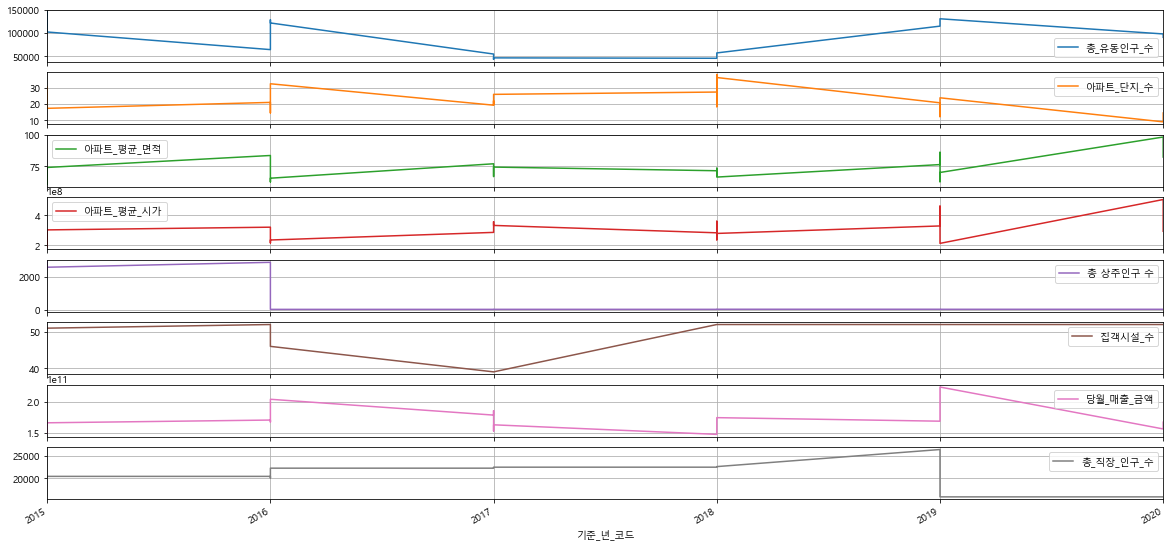

In [29]:
mpl.rcParams['figure.figsize'] = (20, 10)
features.plot(subplots=True)

In [30]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
data_minmax=features.copy()
data_minmax[:]=scaler.fit_transform(data_minmax[:])
data_minmax

,총_유동인구_수,아파트_단지_수,아파트_평균_면적,아파트_평균_시가,총 상주인구 수,집객시설_수,당월_매출_금액,총_직장_인구_수
기준_년_코드,,,,,,,,
2015.0,1.000000,0.735711,0.289413,0.195262,0.867833,0.923077,0.179709,0.414498
2015.0,0.963473,0.664152,0.037872,0.000000,0.845230,0.923077,0.026490,0.404033
2015.0,0.677255,0.610197,0.000000,0.084642,1.000000,0.923077,0.093746,0.404033
2015.0,0.577827,0.285780,0.357055,0.358522,0.889838,0.923077,0.244508,0.432933
2016.0,0.205804,0.411065,0.609829,0.415643,0.993487,1.000000,0.302301,0.432933
2016.0,0.391517,0.188615,0.515413,0.224039,0.000000,1.000000,0.260674,0.397696
2016.0,0.834467,0.473022,0.051788,0.084056,0.000000,0.538462,0.372390,0.397696
2016.0,0.768646,0.804527,0.129998,0.144928,0.000000,0.538462,0.741342,0.606145
2017.0,0.112345,0.352080,0.434737,0.305732,0.000000,0.000000,0.406933,0.606145


In [36]:
data_1496_sort.index=data_1496_sort['기준_년_코드']
y=data_1496_sort['폐업률']
dataset=pd.concat([data_minmax,y],axis=1)
dataset

,총_유동인구_수,아파트_단지_수,아파트_평균_면적,아파트_평균_시가,총 상주인구 수,집객시설_수,당월_매출_금액,총_직장_인구_수,폐업률
기준_년_코드,,,,,,,,,
2015.0,1.000000,0.735711,0.289413,0.195262,0.867833,0.923077,0.179709,0.414498,4.273504
2015.0,0.963473,0.664152,0.037872,0.000000,0.845230,0.923077,0.026490,0.404033,2.693966
2015.0,0.677255,0.610197,0.000000,0.084642,1.000000,0.923077,0.093746,0.404033,3.987069
2015.0,0.577827,0.285780,0.357055,0.358522,0.889838,0.923077,0.244508,0.432933,3.162486
2016.0,0.205804,0.411065,0.609829,0.415643,0.993487,1.000000,0.302301,0.432933,5.147864
2016.0,0.391517,0.188615,0.515413,0.224039,0.000000,1.000000,0.260674,0.397696,2.605863
2016.0,0.834467,0.473022,0.051788,0.084056,0.000000,0.538462,0.372390,0.397696,2.325581
2016.0,0.768646,0.804527,0.129998,0.144928,0.000000,0.538462,0.741342,0.606145,1.892744
2017.0,0.112345,0.352080,0.434737,0.305732,0.000000,0.000000,0.406933,0.606145,2.487047


In [96]:
TRAIN_SPLIT=15 #7:3으로 train, test 분리

- 데이터의 time window 설정
    - 데이터의 연속 샘플 window를 기반으로 일련의 예측을 수행하기 위해 1년간의 time window를 만들고 이 window를 모델에 학습시킨다.
- 아래 함수는 time window를 반환한다. 다음은 window의 input과 label을 지정하는 parameter에 대한 설명이다.
    - history_size : 과거 information window의 크기(몇 개의 과거 데이터를 학습할 것인지)->1년
    - target_size : 예측해야 하는 레이블(얼마나 멀리 있는 예측을 배워야 하는가)->다음 분기

In [97]:
dataset_values=dataset.values

In [103]:
def multivariate_data(dataset,target,start_index,end_index,history_size,target_size,single_step=False):
    df=[]
    labels=[]
    
    start_index+=history_size
    if end_index is None:
        end_index=len(dataset)-target_size
    
    for i in range(start_index,end_index+1):
        indices=range(i-history_size,i)
        df.append(dataset[indices])
        
        if single_step:
            labels.append(target[i])
        else:
            labels.append(target[i:i+target_size])
            
    return np.array(df),np.array(labels)

In [104]:
past_history=4
future_target=1

In [105]:
x_train_single,y_train_single=multivariate_data(dataset_values[:,0:8],dataset_values[:,8],0,TRAIN_SPLIT,past_history,future_target,single_step=True)
x_val_single,y_val_single=multivariate_data(dataset_values[:,0:8],dataset_values[:,8],TRAIN_SPLIT,None,past_history,future_target,single_step=True)

print('Single window of past history : {}'.format(x_train_single[0].shape))

Single window of past history : (4, 8)


In [106]:
x_train_single

array([[[1.00000000e+00, 7.35711020e-01, 2.89413423e-01, 1.95262418e-01,
         8.67832969e-01, 9.23076923e-01, 1.79709032e-01, 4.14498320e-01],
        [9.63472960e-01, 6.64151806e-01, 3.78721156e-02, 0.00000000e+00,
         8.45229520e-01, 9.23076923e-01, 2.64904218e-02, 4.04032645e-01],
        [6.77254641e-01, 6.10196616e-01, 0.00000000e+00, 8.46424089e-02,
         1.00000000e+00, 9.23076923e-01, 9.37460644e-02, 4.04032645e-01],
        [5.77826999e-01, 2.85779607e-01, 3.57054782e-01, 3.58522002e-01,
         8.89838491e-01, 9.23076923e-01, 2.44508145e-01, 4.32933269e-01]],

       [[9.63472960e-01, 6.64151806e-01, 3.78721156e-02, 0.00000000e+00,
         8.45229520e-01, 9.23076923e-01, 2.64904218e-02, 4.04032645e-01],
        [6.77254641e-01, 6.10196616e-01, 0.00000000e+00, 8.46424089e-02,
         1.00000000e+00, 9.23076923e-01, 9.37460644e-02, 4.04032645e-01],
        [5.77826999e-01, 2.85779607e-01, 3.57054782e-01, 3.58522002e-01,
         8.89838491e-01, 9.23076923e-01, 2.

In [107]:
y_train_single

array([5.14786418, 2.60586319, 2.3255814 , 1.89274448, 2.48704663,
       2.35173824, 3.51053159, 2.12765957, 3.87029289, 4.18904404,
       3.67074527, 3.18906606])

In [108]:
x_val_single

array([[[0.13583707, 0.93644262, 0.15395455, 0.28356395, 0.00242402,
         1.        , 0.35317642, 0.63927028],
        [0.70163867, 0.40237769, 0.41782632, 0.44185503, 0.00242402,
         1.        , 0.27843657, 1.        ],
        [0.74151753, 0.10996799, 0.67729435, 0.86102976, 0.00242402,
         1.        , 0.34672682, 0.24253481],
        [0.80416332, 0.27160494, 0.05548705, 0.10784273, 0.00242402,
         1.        , 0.40973809, 0.24253481]],

       [[0.70163867, 0.40237769, 0.41782632, 0.44185503, 0.00242402,
         1.        , 0.27843657, 1.        ],
        [0.74151753, 0.10996799, 0.67729435, 0.86102976, 0.00242402,
         1.        , 0.34672682, 0.24253481],
        [0.80416332, 0.27160494, 0.05548705, 0.10784273, 0.00242402,
         1.        , 0.40973809, 0.24253481],
        [0.85707705, 0.50823045, 0.25118901, 0.07362183, 0.00173145,
         1.        , 1.        , 0.        ]],

       [[0.74151753, 0.10996799, 0.67729435, 0.86102976, 0.00242402,
       

In [109]:
y_val_single

array([2.03106332, 3.63836825, 2.5871766 ])

- Base line(기준 설정)
    - 입력 지점이 주어지면 모든 기록을 보고 다음 지점이 마지막 20개 관측치의 평균이 될 것으로 예측함

In [115]:
def create_time_steps(length):
    return list(range(-length,0))

In [116]:
def show_plot(plot_data,delta,title):
    labels=['History','True Future','Model Prediction']
    maker=['.-','rx','go']
    time_steps=create_time_steps(plot_data[0].shape[0])
    if delta:
        future=delta
    else:
        future=0
        
    plt.title(title)
    for i,x in enumerate(plot_data):
        if i:
            plt.plot(future,plot_data[i],marker[i],markersize=10,label=labels[i])
        else:
            plt.plot(time_stpes,plot_data[i].flatten(),marker[i],label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0],(future+5)*2])
    plt.xlabel('Time-Step')
    return plt

In [ ]:
show_plot([x_train_single[0],y_train_single[0]],0,'Sample Example')

In [113]:
def baseline(history):
    return np.mean(history)

In [ ]:
show_plot([x_train_single[0],y_train_single[0],baseline(x_train_single[0])],0,'Baseline Prediction Example')

- RNN(Recurrent Neural Network) 활용
    - 시계열을 단계별로 처리하여 지금까지 본 정보를 요약하여 내부 상태를 유지함
    - LSTM이라고 불리는 RNN의 Layer를 사용
    - 시계열 데이터에 적합한 신경 네트워크 모델
    - tf.data를 셔플, 배치, 캐시하는데 사용

In [ ]:
BATCH_SIZE=4
BUFFER_SIZE=10000

In [ ]:
train_data_single=tf.data.Dataset.from_tensor_slices((x_train_single,y_train_single))
train_data_single=train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single=tf.data.Dataset.from_tensor_slices((x_val_single,y_val_single))
val_data_single=val_univariate.batch(BATCH_SIZE).repeat()

In [ ]:
lstm_model=tf.keras.models.Sequential()
lstm_model.add(tf.keras.layers.LSTM(32,input_shape=x_train_single.shape[-2:]))
lstm_model.add(tf.keras.layers.Dense(1))

lstm_model.compile(optimizer='adam',loss='mae')

In [ ]:
for x,y in val_data_single.take(1):
    print(lstm_model.predict(x).shape)

In [ ]:
EVALUATION_INTERVAL=200
EPOCHS=10

single_step_history=lstm_model.fit(train_data_single,epochs=EPOCHS,
                                         steps_per_epoch=EVALUATION_INTERVAL,
                                         validation_data=val_data_single,
                                         validation_steps=50)

In [ ]:
def plot_train_history(history,title):
    loss=history.history['loss']
    val_loss=history.history['val_loss']
    
    epochs=range(len(loss))
    
    plt.figure()
    
    plt.plot(epochs,loss,'b',label='Training loss')
    plt.plot(epochs,val_loss,'r',label='Validation loss')
    plt.title(title)
    plt.legend()
    
    plt.show()

In [ ]:
plot_train_history(single_step_history,'Single Step Training and Validation loss')

In [ ]:
for x,y in val_data_single.take(3):
    plot=show_plot([x[0]][:,1].numpy(),y[0].numpy(),
                   lstm_model.predict(x)[0],12,
                   'Simple LSTM Model')
    plt.show()